source: https://www.kaggle.com/code/robikscube/train-your-first-pytorch-model-card-classifier#Bonus:-Evaluating-the-Results

In [1]:
# Pytorch
import torch
from torch import nn
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader

# Torchvision: make working with image files easier
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# progress bar
from tqdm import tqdm 

# optimizer
import torch.optim as optim

In [2]:
class SyntheticDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform) 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes # returns dataset classes from ImageFolder

In [3]:
class SyntheticDataClassifier(nn.Module):
    def __init__(self, num_classes=2, weights='DEFAULT'):
        super(SyntheticDataClassifier, self).__init__()
        self.model = resnet18(weights=weights)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)  # Modify the last fully connected layer
    
    def forward(self, x):
        return self.model(x)

In [13]:
# Define the transformation operation that suits resnet18
weights = ResNet18_Weights.DEFAULT
transform_operation = weights.transforms() 

# Create a dataset object
train_data = SyntheticDataset(data_dir='dataset\\train', transform=transform_operation)
test_data = SyntheticDataset(data_dir='dataset\\test', transform=transform_operation)

# Create a DataLoader object for training - faster training in batches
train_loader = DataLoader(train_data, batch_size=32, shuffle=True) 
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# size of the training dataset
print(len(train_data))

1129


In [11]:
# Get a dictionary associating target values with folder names
data_dir = 'dataset\\train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'bad', 1: 'good'}


In [12]:
# Training the model
num_epochs = 10
train_losses = []
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
    
model = SyntheticDataClassifier(num_classes=2, weights=weights).to(device)    
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc='Training loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}")

cuda


Training loop: 100%|██████████| 36/36 [00:12<00:00,  2.78it/s]


Epoch 1/10, Training Loss: 0.8347634684205372


Training loop: 100%|██████████| 36/36 [00:11<00:00,  3.09it/s]


Epoch 2/10, Training Loss: 0.625417126344304


Training loop: 100%|██████████| 36/36 [00:13<00:00,  2.62it/s]


Epoch 3/10, Training Loss: 0.5555359964828981


Training loop: 100%|██████████| 36/36 [00:20<00:00,  1.72it/s]


Epoch 4/10, Training Loss: 0.48626207817012596


Training loop: 100%|██████████| 36/36 [00:13<00:00,  2.58it/s]


Epoch 5/10, Training Loss: 0.3575028688956194


Training loop: 100%|██████████| 36/36 [00:13<00:00,  2.58it/s]


Epoch 6/10, Training Loss: 0.3749229611286133


Training loop: 100%|██████████| 36/36 [00:12<00:00,  2.87it/s]


Epoch 7/10, Training Loss: 0.2136942324937182


Training loop: 100%|██████████| 36/36 [00:13<00:00,  2.60it/s]


Epoch 8/10, Training Loss: 0.24744433291302623


Training loop: 100%|██████████| 36/36 [00:11<00:00,  3.19it/s]


Epoch 9/10, Training Loss: 0.10932971279741495


Training loop: 100%|██████████| 36/36 [00:11<00:00,  3.15it/s]

Epoch 10/10, Training Loss: 0.1323796337663441


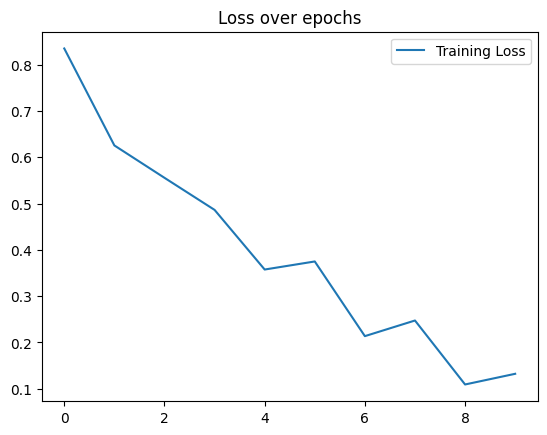

In [14]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

# Test dataset to determine the accuracy

In [15]:
model.eval()

# Initialize variables for accuracy calculation
correct = 0
total = 0

# Disable gradient computation
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        # Move images and labels to the device (assuming you're using GPU)
        images, labels = images.cuda(), labels.cuda()
        
        # Forward pass
        outputs = model(images)
        
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Total number of labels
        total += labels.size(0)
        
        # Total correct predictions
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print('Accuracy on the test set: {:.2f}%'.format(accuracy))

100%|██████████| 5/5 [00:01<00:00,  3.95it/s]

Accuracy on the test set: 80.58%


# Inference

In [16]:
# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

In [17]:
# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

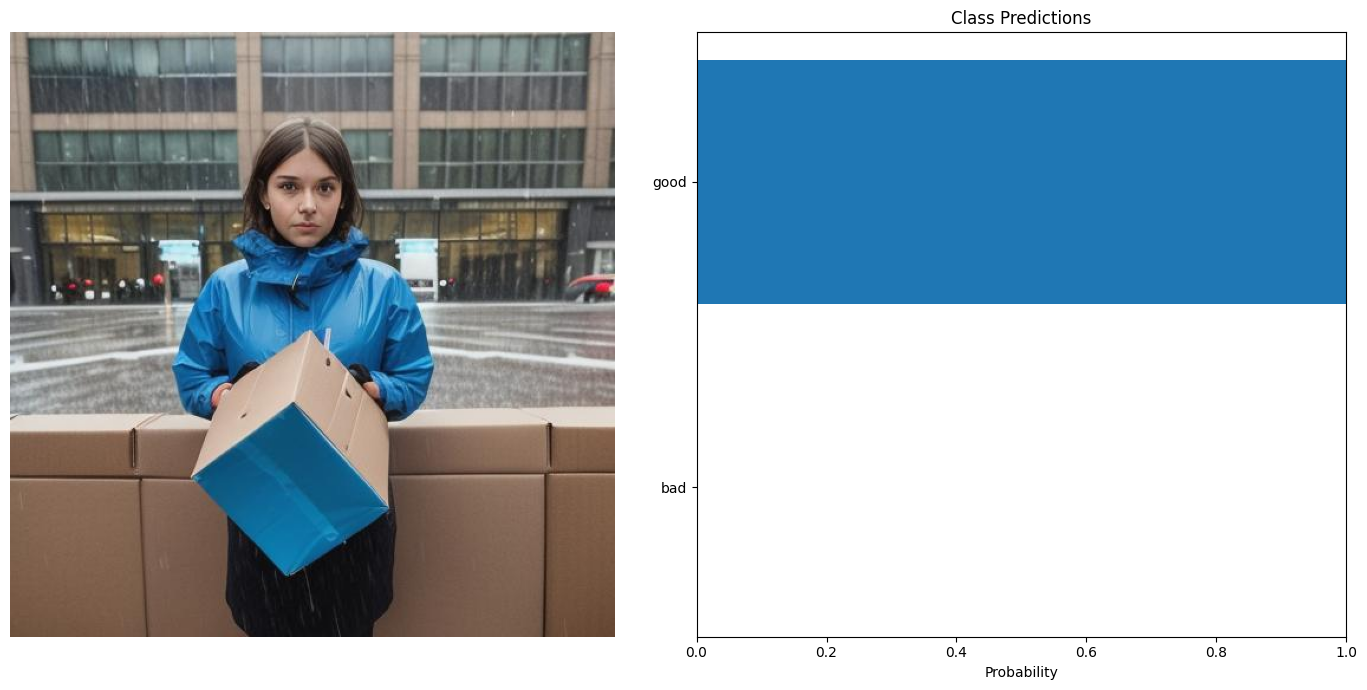

[9.3162799e-04 9.9906844e-01]


In [40]:
from PIL import Image
# Example usage
test_image = "data\\110_1.jpg"
original_image, image_tensor = preprocess_image(test_image, transform_operation) # determined earlier in the code
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = train_data.classes 
visualize_predictions(original_image, probabilities, class_names)
print(probabilities)

In [41]:
# Run inference write to directory
import os

directory = 'data\\'
files = os.listdir(directory)
sorted_files = sorted(files, key=lambda x: (int(x.split('_')[0]), int(x.split('_')[1].split('.')[0])))

In [42]:
for file in sorted_files:
    
    original_image, image_tensor = preprocess_image("data\\" + file, transform_operation) # determined earlier in the code
    probabilities = predict(model, image_tensor, device)
    print(probabilities)
    
    if probabilities[0] < probabilities[1]:
        print(f"Image {file} is good, writing to good directory")
        original_image.save(f'results\\good\\{file}')
    else:
        print(f"Image {file} is bad, writing to bad directory")
        #original_image.save(f'results\\bad\\{file}')

[0.5589461  0.44105396]
Image 1_1.jpg is bad, writing to bad directory
[9.9906605e-01 9.3400199e-04]
Image 1_2.jpg is bad, writing to bad directory
[0.998114   0.00188599]
Image 2_1.jpg is bad, writing to bad directory
[0.28410155 0.71589845]
Image 2_2.jpg is good, writing to good directory
[0.98671687 0.01328312]
Image 3_1.jpg is bad, writing to bad directory
[0.60216427 0.3978357 ]
Image 3_2.jpg is bad, writing to bad directory
[9.995964e-01 4.035706e-04]
Image 4_1.jpg is bad, writing to bad directory
[0.9582337 0.0417663]
Image 4_2.jpg is bad, writing to bad directory
[0.16307496 0.8369251 ]
Image 5_1.jpg is good, writing to good directory
[0.2748014 0.7251986]
Image 5_2.jpg is good, writing to good directory
[0.06560623 0.93439376]
Image 6_1.jpg is good, writing to good directory
[0.98594123 0.01405875]
Image 6_2.jpg is bad, writing to bad directory
[1.0000000e+00 7.9178655e-09]
Image 7_1.jpg is bad, writing to bad directory
[0.08987586 0.9101242 ]
Image 7_2.jpg is good, writing to